# Time series : Analyses et prédictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import time

# Importer et afficher une série temporelle

In [2]:
# récupération du jeu de données
df = pd.read_csv('data\weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# chargement du climat en local
climatsaus = pd.read_csv("data\climatsAUS_v2.csv",sep=";")
climatsaus.head()

,Location,Climat_Koppen
0,Uluru,BSh
1,Woomera,Bwh
2,Adelaide,Csa
3,Albany,Csb
4,MountGambier,Csb


In [4]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.
climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'}

climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)

In [5]:
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")

In [96]:
data = pd.pivot_table(df, index=['Date'], columns=['Clim_type'], values=['Rainfall'], aggfunc=np.sum).reset_index()
data['Date']=pd.to_datetime(data['Date'])
data.set_index(['Date'] , inplace=True)
data = data.resample('W').sum()

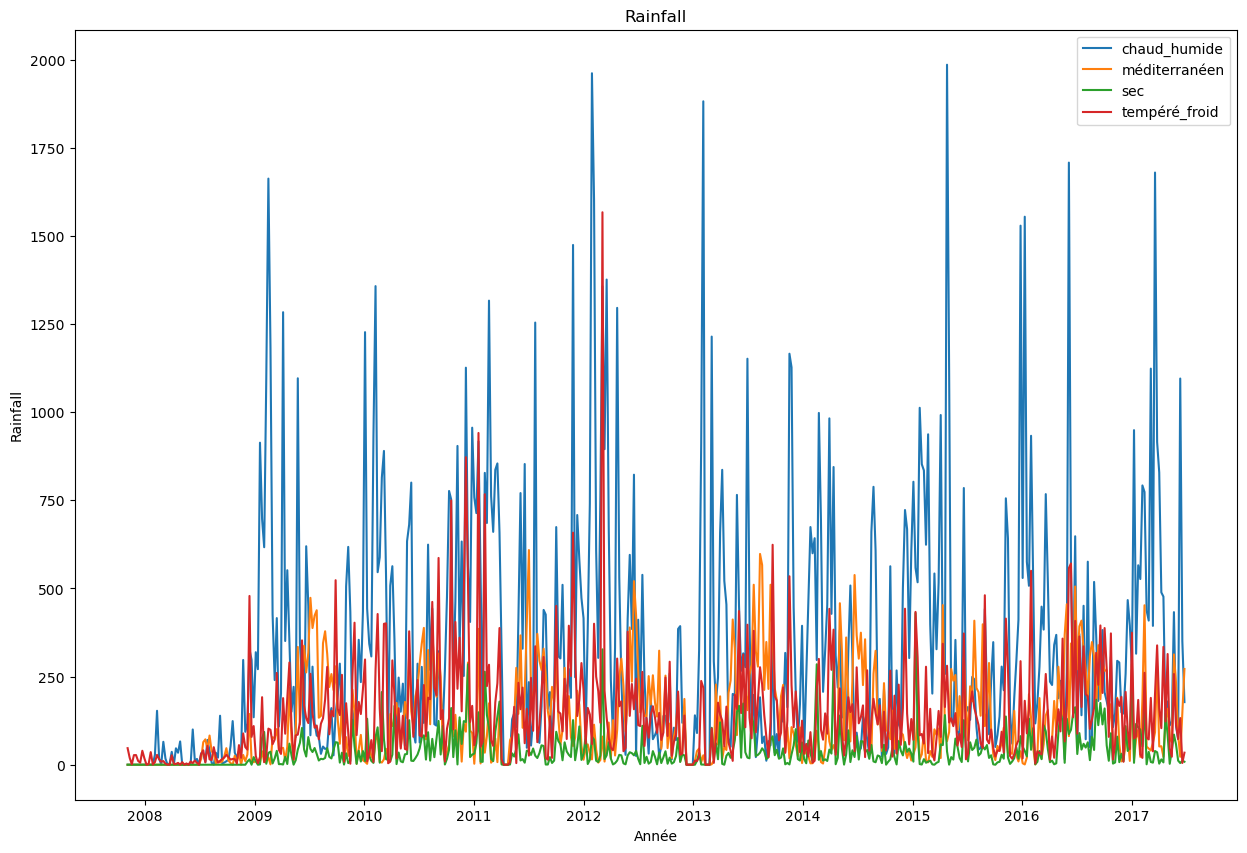

In [97]:
plt.figure(figsize=(15,10))
plt.plot(data, label=data.columns.droplevel())
plt.title('Rainfall')
plt.xlabel('Année')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [53]:
location = df.groupby(['Location'])['Location'].count().sort_values()>3000
location = location[location.values==True].index

In [106]:
data=pd.DataFrame()
Clim_type = 'chaud_humide'

for loc in location:
    if climatsaus[climatsaus['Location']==loc]['Clim_type'].values[0] == Clim_type:
        df1=df[df['Location']==loc][['Date','Rainfall']]
        df1['Date']=pd.to_datetime(df1['Date'])
        df1.set_index(['Date'] , inplace=True)
        df1 = df1.resample('d').mean().ffill()
        df1 = df1.resample('W').sum()
        data = pd.concat([data,df1])

data.rename({'Rainfall': Clim_type} , axis=1, inplace=True)
data = data.resample('W').sum()

<AxesSubplot:xlabel='Date'>

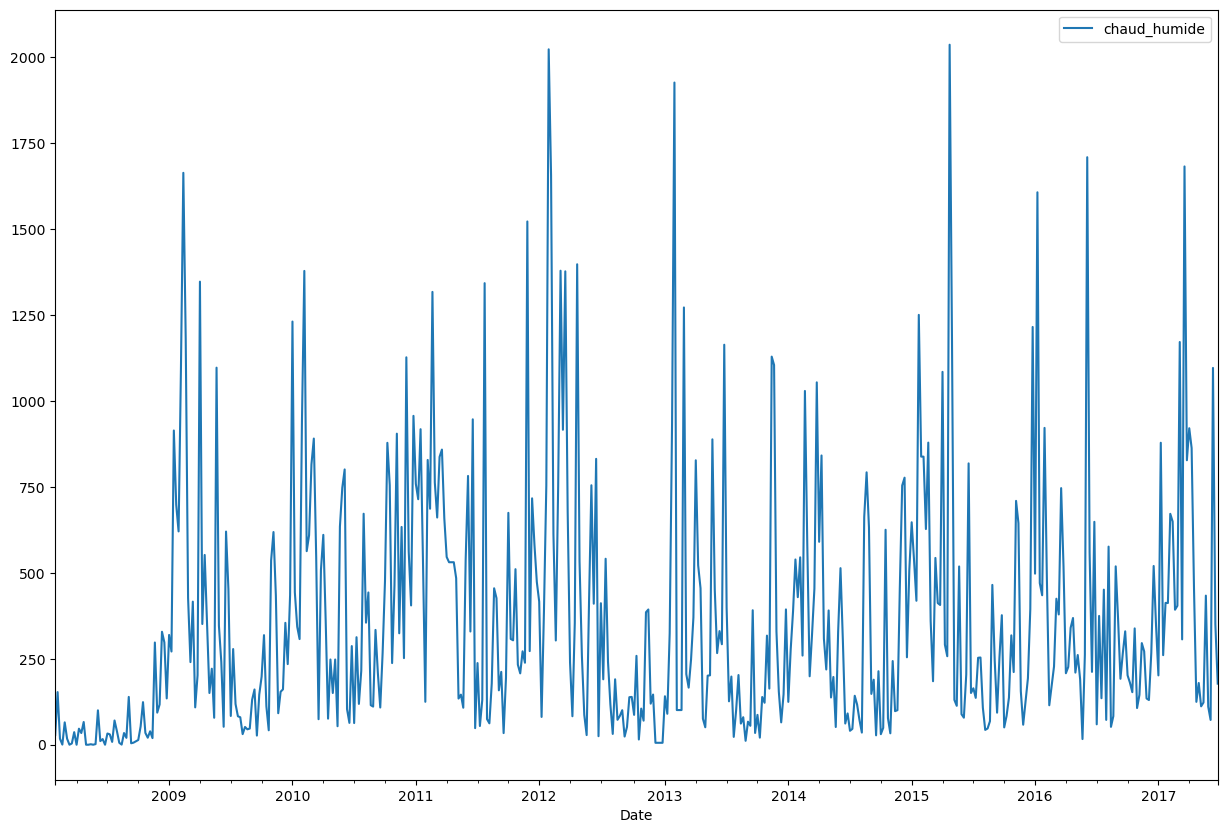

In [108]:
data.plot(figsize=(15,10))

In [152]:
# L'année 2008 ne semble pas significative dans notre analyse ==> suppression de l'année 2008

In [109]:
data = data.loc[pd.to_datetime('2009-01-02'):, :]

## Décomposition automatique de la série temporelle

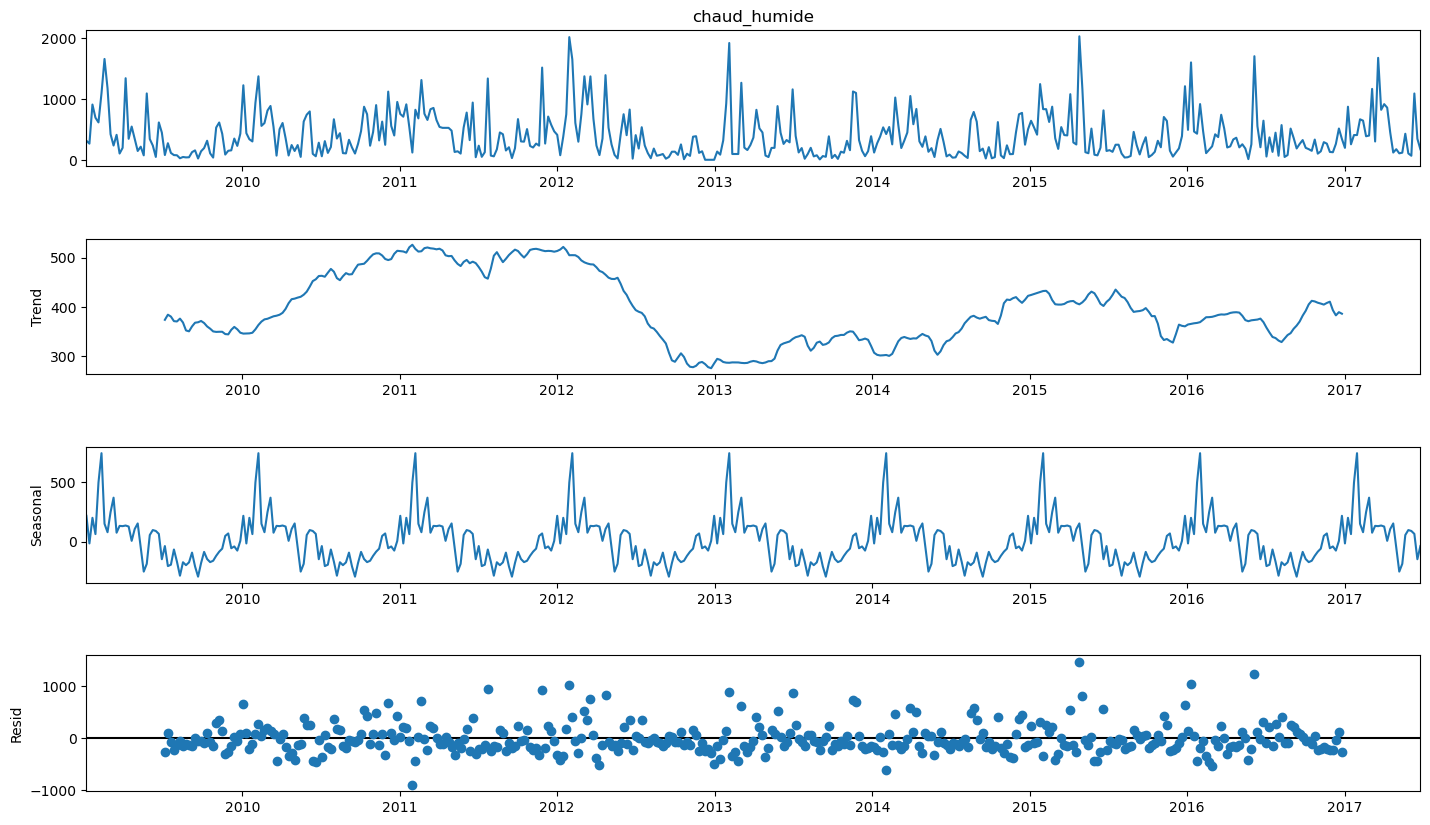

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data.iloc[:,0], period=52)
fig = res.plot()
fig.set_size_inches((16, 9))
plt.show()

# Entraînement d'un modèle SARIMA

### Autocorrélation et différenciation

In [111]:
data_1 = data.diff().dropna() #Differenciation simple 

C:\Users\OlivierAmable\anaconda3\envs\pyenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


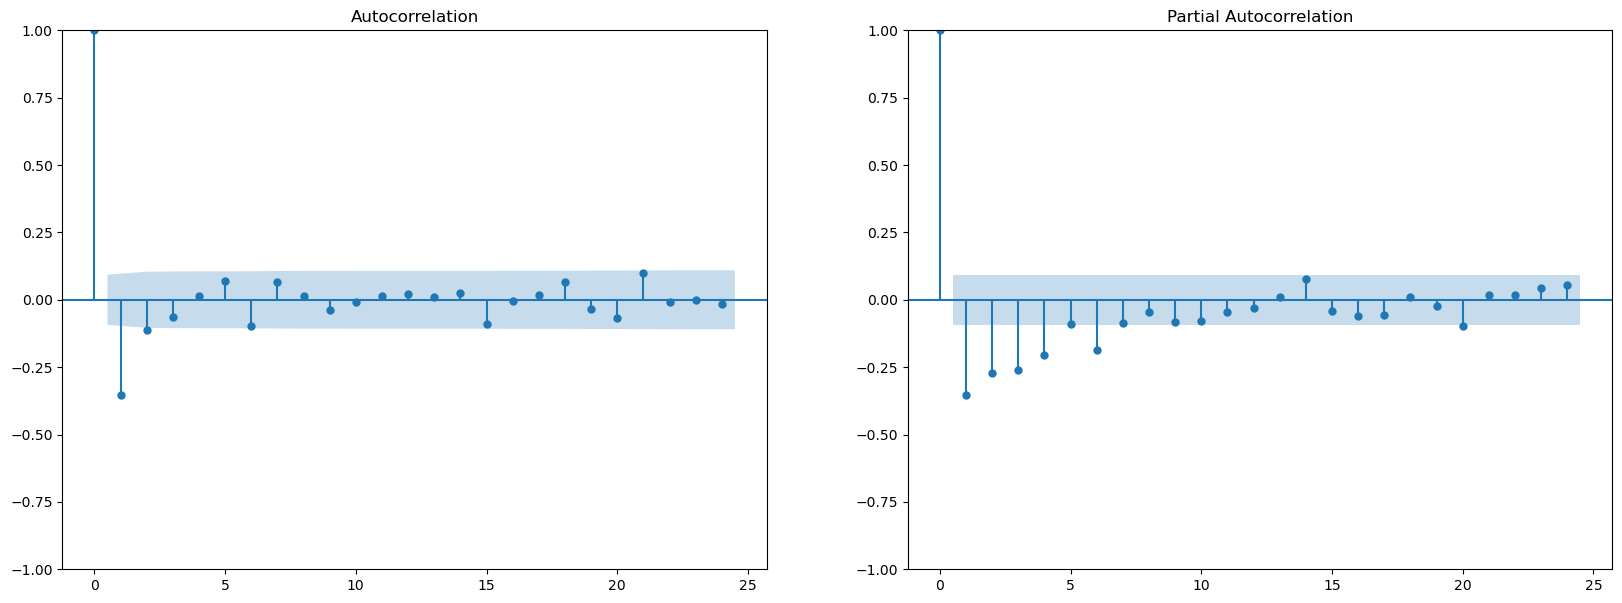

In [112]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(data_1.iloc[:,0], lags = 24, ax=ax1)
plot_pacf(data_1.iloc[:,0], lags = 24, ax=ax2)
plt.show()

In [113]:
# ACF s'annule après l'ordre 1
# PACF tends vers 0
# On choisit donc un modèle MA(1) ce qui est équivalent à un  ARMA(0,1)

In [114]:
data_2 = data_1.diff(periods = 52).dropna() #Différenciation d'ordre 52 (semaines)

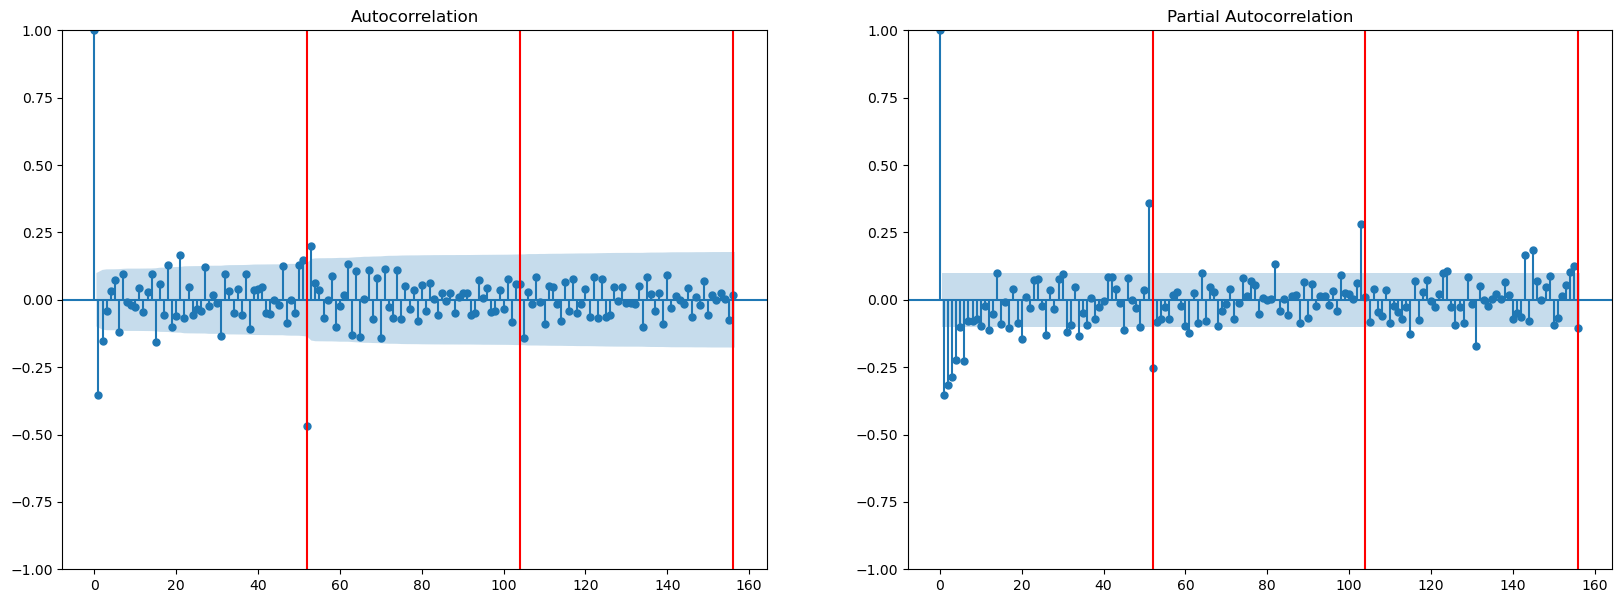

In [115]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(data_2.iloc[:,0], lags = 52*3, ax=ax1)
ax1.axvline(x= 52, color='red')
ax1.axvline(x= 52*2, color='red')
ax1.axvline(x= 52*3, color='red')
plot_pacf(data_2.iloc[:,0], lags = 52*3, ax=ax2)
ax2.axvline(x= 52, color='red')
ax2.axvline(x= 52*2, color='red')
ax2.axvline(x= 52*3, color='red')
plt.show()

In [116]:
# Concernant la partie saisonnière :
# ACF S'annule après l'ordre 1
# PACF semble tendre vers 0
# On choisit donc un modèle MA(1) ce qui est équivalent à un  ARMA(0,1)

### Entraînement et sélection du modèle

In [117]:
model=sm.tsa.SARIMAX(data.iloc[:,0],order=(0,1,1),seasonal_order=(0,1,1,52))
sarima=model.fit()
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       chaud_humide   No. Observations:                  443
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2874.473
Date:                            Wed, 02 Nov 2022   AIC                           5754.946
Time:                                    11:49:06   BIC                           5766.844
Sample:                                01-04-2009   HQIC                          5759.662
                                     - 06-25-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      0.276     -3.622      0.000      -1.541      -0.459
ma.S.L52      -0.9845      0.929   

In [120]:
model=sm.tsa.SARIMAX(data.iloc[:,0],order=(1,1,1),seasonal_order=(1,1,0,52))
sarima=model.fit()
print(sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        chaud_humide   No. Observations:                  443
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood               -2899.193
Date:                             Wed, 02 Nov 2022   AIC                           5806.386
Time:                                     11:49:17   BIC                           5822.251
Sample:                                 01-04-2009   HQIC                          5812.675
                                      - 06-25-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2440      0.052      4.691      0.000       0.142       0.346
ma.L1         -0.9999      

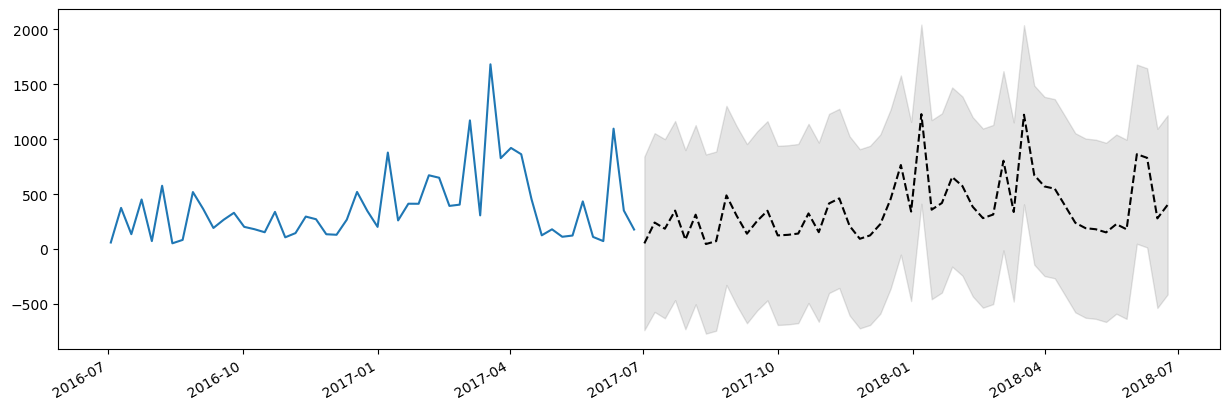

In [121]:
prediction = sarima.get_forecast(steps =52).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(data.iloc[-52:,0])

prediction['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance


In [122]:
# L'intervalle de confiance est grand
# Malgré différents scénarii utilisés, les paramètres ne  sont pas significatifs et le modèle n'est pas satisfaisant